In [13]:
# Import libries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import datetime as dt
from scipy import stats
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

In [22]:
# Import dataframes AND Specify a custom delimiter for the CSV input (sep=' ')

cabotage_df=pd.read_csv(r'C:\Users\jspad\Documents\Code Academy\Final Project\Dataset\Cabotage by country\Cabotage custom linear.csv', sep=';')


In [23]:
cabotage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2812 entries, 0 to 2811
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit         2812 non-null   object 
 1   c_cabot      2812 non-null   object 
 2   geo          2812 non-null   object 
 3   TIME_PERIOD  2812 non-null   int64  
 4   OBS_VALUE    1895 non-null   float64
 5   OBS_FLAG     917 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 131.9+ KB


In [24]:
cab1=cabotage_df.fillna(0).drop(columns=['OBS_FLAG'])
cab1["unit"].replace({"THS_T": "1000t"}, inplace=True)
cab1["c_cabot"].replace({"BE": "Belgium"}, inplace=True)
cab1["c_cabot"].replace({"DE": "Germany"}, inplace=True)
cab1["c_cabot"].replace({"FR": "France"}, inplace=True)
cab1["c_cabot"].replace({"IT": "Italy"}, inplace=True)
cab1["c_cabot"].replace({"NL": "Netherlands"}, inplace=True)
cab1["c_cabot"].replace({"PL": "Poland"}, inplace=True)
cab1["c_cabot"].replace({"RO": "Romania"}, inplace=True)


In [25]:
cab1['c_cabot'] = pd.Categorical(cab1['c_cabot'],
categories=['Belgium', 'Germany', 'France', 'Italy', 'Netherlands', 'Poland', 'Romania'])

In [26]:
# Creation of Dataset by Country

cab_de=cab1.loc[cab1['c_cabot'] == 'Germany']
cab_be=cab1.loc[cab1['c_cabot'] == 'Belgium']
cab_fr=cab1.loc[cab1['c_cabot'] == 'France']
cab_it=cab1.loc[cab1['c_cabot'] == 'Italy']
cab_nl=cab1.loc[cab1['c_cabot'] == 'Netherlands']
cab_pl=cab1.loc[cab1['c_cabot'] == 'Poland']
cab_ro=cab1.loc[cab1['c_cabot'] == 'Romania']

In [27]:
cab_de.head()

cab_de.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 429 to 940
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   unit         512 non-null    object  
 1   c_cabot      512 non-null    category
 2   geo          512 non-null    object  
 3   TIME_PERIOD  512 non-null    int64   
 4   OBS_VALUE    512 non-null    float64 
dtypes: category(1), float64(1), int64(1), object(2)
memory usage: 20.8+ KB


In [28]:
# Exporting Dataset in XLSX

cab_de = pd.DataFrame(cab_de)

cab_de.to_excel(r'C:\Users\jspad\Documents\Code Academy\Final Project\Dataset\cabotageDE.xlsx')  

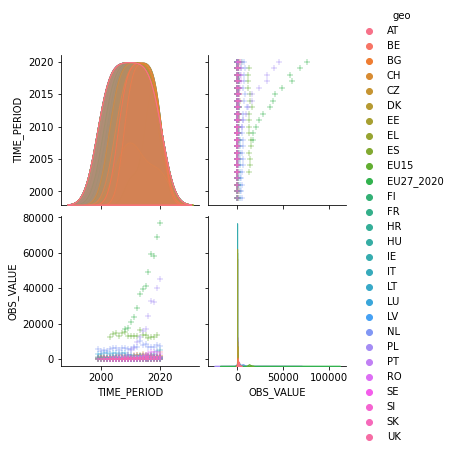

In [29]:
#Pairplot General

tmp = cab_de.iloc[:, lambda df: [2, 3, 4]]
g = sns.pairplot(tmp, hue='geo', markers='+')
plt.show()

In [3]:
# Importing with reset index

# products = pd.read_excel(r'C:\Users\jspad\Documents\Code Academy\Sqlite Projects\sales original.xlsx', 
#     sheet_name='products', header=0)
# products.reset_index(inplace=True) # we are creating an index column because, in this particular sales dataset, no value is necessarily unique, except for the index
# products=products.rename(columns={"index": "index_col"}) # we need to change the name of the column to something else

# stock = pd.read_excel(r'C:\Users\jspad\Documents\Code Academy\Sqlite Projects\sales original.xlsx', 
#     sheet_name='stock', header=0)
# stock.reset_index(inplace=True) 
# stock=stock.rename(columns={"index": "index_col"}) 

# assessment = pd.read_excel(r'C:\Users\jspad\Documents\Code Academy\Sqlite Projects\sales original.xlsx', 
#     sheet_name='assessment', header=0)
# assessment.reset_index(inplace=True) 
# assessment=assessment.rename(columns={"index": "index_col"}) 

# invoices = pd.read_excel(r'C:\Users\jspad\Documents\Code Academy\Sqlite Projects\sales original.xlsx', 
#     sheet_name='invoices', header=0)
# invoices.reset_index(inplace=True) 
# invoices=invoices.rename(columns={"index": "index_col"}) 

# customers = pd.read_excel(r'C:\Users\jspad\Documents\Code Academy\Sqlite Projects\sales original.xlsx', 
#     sheet_name='customers', header=0)
# customers.reset_index(inplace=True) 
# customers=customers.rename(columns={"index": "index_col"}) 



In [4]:
#Merging datasets

part_df=pd.merge(products, stock, on="index_col")
part_df=part_df.drop(['ASIN_y'], axis=1)

part2_df=pd.merge(part_df, assessment, on="index_col")
part2_df=part2_df.drop(['ASIN_x'], axis=1)

part3_df=pd.merge(part2_df, invoices, on="index_col")
part3_df=part3_df.drop(['ASIN_y'], axis=1)

full_df=pd.merge(part3_df, customers, on="index_col")
full_df=full_df.drop(['CustomerID_y', 'index_col'], axis=1)


In [17]:
# Dropping columns

df=df.drop(['invoice_time', 'StockCode'], axis=1)

# Data cleaning - checking missing values (Customerid missing) 
#np.issubdtype(df['CustomerID_x'].dtype, np.number)

df=df[pd.to_numeric(df['CustomerID_x'], errors='coerce').notnull()]

# Data cleaning - checking missing values (Customerid missing) 

df_country=df[pd.to_numeric(df['CustomerID_x'], errors='coerce').notnull()]

# Rename
df=df.rename(columns={"title": "Description",
                                "ASIN_x": "ASIN",
                                "CustomerID_x": "CustomerID"})

# Transforming these labels into categrical data type

df['product_type'] = pd.Categorical(df['product_type'],
categories=['dslr camera', 'keyboard', 'monitor', 'mouse', 'processor', 'smartphone',])


df['Country'] = pd.Categorical(df['Country'],
categories=['Australia','Austria','Bahrain','Belgium','Brazil','Canada','Cyprus','Czech Republic','Denmark','European Community','Finland','France','Germany','Greece',
            'Iceland','Ireland','Israel','Italy','Japan','Lebanon','Lithuania','Malta','Netherlands','Norway','Poland','Portugal','Saudi Arabia','Singapore',
            'South Africa','Spain','Sweden','Switzerland','United Arab Emirates','United Kingdom','United States','Unknown'])

In [19]:
df.sort_values(by=['total_sale'], ascending=False)

# Pivot Table per Invoice

table_invoice = pd.pivot_table(df, values='total_sale', index=['InvoiceNo', 'Country'],
                    aggfunc=np.sum,
                    observed=True)

table_invoice=table_invoice.sort_values(by=['total_sale'], ascending=False)


table_invoice

,,total_sale
InvoiceNo,Country,
78581483,Germany,6146710.55
78541431,Germany,4433604.10
78567423,Germany,2557541.80
78572035,Netherlands,2015225.88
78563614,Australia,1971091.60
...,...,...
78556456,Germany,7.90
78567642,Switzerland,7.65
78546480,Germany,6.99


In [20]:
# Pivot tabel per Customer

table_customer = pd.pivot_table(df, values='total_sale', index=['CustomerID', 'Country', 'product_type'],
                    aggfunc=np.sum,
                    observed=True)

table_customer=table_customer.sort_values(by=['total_sale'], ascending=False)

table_customer

total_sale
CustomerID Country     product_type            
16446      Germany     smartphone    6146710.55
14646      Netherlands processor     6099500.87
                       dslr camera   5755968.52
                       smartphone    5395203.56
12346      Germany     processor     4433604.10
...                                         ...
14816      Germany     smartphone          6.99
17889      Germany     mouse               6.89
14089      Germany     mouse               6.80
16679      Germany     smartphone          5.98
16517      Germany     processor           5.98

[23313 rows x 1 columns]

In [24]:
t_sales=df.groupby('CustomerID')['total_sale'].agg(['sum','count','mean']).sort_values(by=['sum'], ascending=False)

t_sales.describe()

,sum,count,mean
count,4.339000e+03,4339.000000,4.339000e+03
mean,1.276793e+05,95.667665,3.966584e+03
std,5.580633e+05,239.437276,7.693713e+04
min,1.398000e+01,1.000000,6.990000e+00
25%,1.468394e+04,18.000000,4.812517e+02
50%,3.917791e+04,43.000000,8.738696e+02
75%,1.029205e+05,104.000000,1.467614e+03
max,2.166474e+07,8205.000000,4.433604e+06


In [23]:
# Pivot tabel per Category of Product

table_product = pd.pivot_table(df_country, values='total_sale', index=[ 'product_type'],
                    aggfunc=np.sum,
                    observed=True)

table_product=table_product.sort_values(by=['total_sale'], ascending=False)

table_product.sort_values(by=['total_sale'], ascending=False).round()

,total_sale
product_type,
processor,151743897.0
smartphone,144634928.0
dslr camera,114769008.0
keyboard,63959978.0
monitor,47919523.0
mouse,30973291.0


In [148]:
# # Which countries and which customers made the highest number of orders? Are they the same with the highest spending?


# country_sales=df_country.groupby('Country')['total_sale'].agg(['sum','count','mean']).sort_values(by=['count'], ascending=False)

# country_sales


,sum,count,mean
Country,,,
Germany,4.567605e+08,370563,1232.612216
United Kingdom,1.238764e+07,9827,1260.571785
France,1.149104e+07,8434,1362.466175
Ireland,1.530354e+07,7603,2012.829133
Spain,2.754244e+06,2551,1079.672407
Netherlands,2.200264e+07,2448,8988.007185
Belgium,2.474314e+06,2004,1234.687570
Switzerland,2.730491e+06,1889,1445.468894
Portugal,1.707936e+06,1527,1118.490956


In [ ]:
# IRQ

# Select the first quantile
q1 =df['total_sale'].quantile(.25)

# Select the third quantile
q3 = df['total_sale'].quantile(.75)

# Create a mask inbeetween q1 & q3
mask = df['total_sale'].between(q1, q3, inclusive=True)

# Filtering the initial dataframe with a mask
iqr = df.loc[mask, 'total_sale']

In [37]:
# Create a filtered DF

df2=df.drop(['Description',	'product_type', 'rating', 'review_count', 'ASIN', 'InvoiceNo', 'Quantity','price', 'CustomerID', 'Country'], axis=1)
df_filtered = df2[df2['total_sale'] <= 648]
df_filtered2 = df_filtered[df_filtered['total_sale'] >= 60]
df_filtered2.info

<bound method DataFrame.info of         total_sale        invoice_date
1           159.96 2018-12-01 17:00:00
3           199.99 2018-12-01 17:00:00
5           335.86 2018-12-01 17:00:00
6            71.70 2018-12-01 17:00:00
7           395.00 2018-12-01 17:00:00
...            ...                 ...
554411      543.68 2019-12-09 08:00:00
554412      179.88 2019-12-09 08:00:00
554413      179.94 2019-12-09 08:00:00
554414       83.64 2019-12-09 08:00:00
554415      279.80 2019-12-09 08:00:00

[206005 rows x 2 columns]>

In [ ]:
#%reset